In [11]:
import pandas as pd

df = pd.read_csv('Data\Merged SPI & NDVI & VPD\Cleaned\merged_file_2001_2022.csv')
df.shape

<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\2693433269.py:3: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv('Data\Merged SPI & NDVI & VPD\Cleaned\merged_file_2001_2022.csv')


(3458, 5)

In [12]:
df = df[~df['Date'].str.contains('2023')]
df.shape

(3432, 5)

In [13]:
df.to_csv('Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\2130012580.py:1: SyntaxWarning: invalid escape sequence '\M'
  df.to_csv('Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv', index=False)


<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1064056707.py:6: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv")


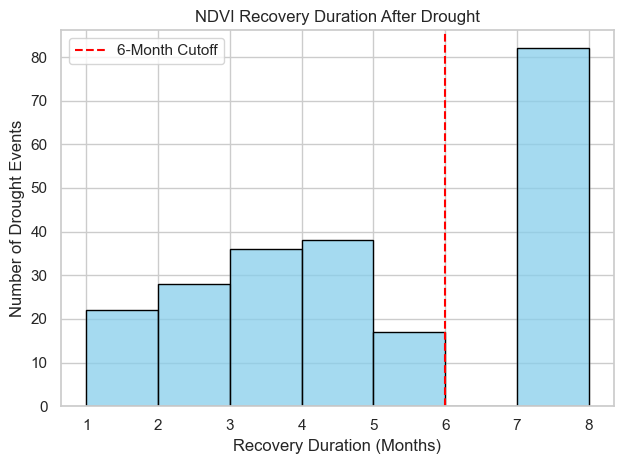

169/251 droughts (67.33%) recovered within 6 months.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your CSV file
df = pd.read_csv("Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv")

df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Step 2: Sort by Region and Date
df.sort_values(by=["Region_Name", "Date"], inplace=True)

# Step 3: Initialize list to store recovery durations
recovery_durations = []

# Step 4: Loop through each region
regions = df["Region_Name"].unique()

for region in regions:
    region_df = df[df["Region_Name"] == region].reset_index(drop=True)

    i = 0
    while i < len(region_df):
        # Find drought start (SPI < -1)
        if region_df.loc[i, "SPI"] < -1:
            drought_start = region_df.loc[i, "Date"]
            baseline_ndvi = region_df.loc[max(0, i-2):i, "NDVI"].mean()  # 3-month window before drought

            # Find drought end (SPI ≥ -0.5)
            drought_end = None
            for j in range(i+1, len(region_df)):
                if region_df.loc[j, "SPI"] >= -0.5:
                    drought_end = region_df.loc[j, "Date"]
                    drought_end_idx = j
                    break

            if drought_end:
                recovered = False
                # Step through next 6 months to find NDVI recovery
                for k in range(drought_end_idx, min(drought_end_idx+6, len(region_df))):
                    if (region_df.loc[k, "SPI"] >= -0.5) and (region_df.loc[k, "NDVI"] >= baseline_ndvi):
                        recovery_duration = (region_df.loc[k, "Date"] - drought_end).days // 30
                        recovery_durations.append(min(recovery_duration, 6))
                        recovered = True
                        break

                if not recovered:
                    recovery_durations.append(7)  # Not recovered in 6 months

                i = drought_end_idx + 6  # Skip forward to avoid overlapping droughts
            else:
                i += 1
        else:
            i += 1

# Step 5: Create histogram
sns.histplot(recovery_durations, bins=range(1, 9), kde=False, color="skyblue", edgecolor='black')
plt.axvline(x=6, color='red', linestyle='--', label='6-Month Cutoff')
plt.xlabel("Recovery Duration (Months)")
plt.ylabel("Number of Drought Events")
plt.title("NDVI Recovery Duration After Drought")
plt.legend()
plt.tight_layout()
plt.show()

# Step 6: Report % recovered in ≤6 months
within_6 = sum([1 for d in recovery_durations if d <= 6])
total = len(recovery_durations)
print(f"{within_6}/{total} droughts ({(within_6/total)*100:.2f}%) recovered within 6 months.")


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load your CSV file
df = pd.read_csv("Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv")

# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Sort and prepare
df = df.sort_values(["Region_Name", "Date"]).reset_index(drop=True)

# Define windows
window_lengths = [1, 2, 3]

# Store adjusted NDVI values per region and window
region_adj_ndvi = defaultdict(lambda: defaultdict(list))

# Loop through each region
for region in df["Region_Name"].unique():
    region_df = df[df["Region_Name"] == region].sort_values("Date").reset_index(drop=True)

    for i in range(3, len(region_df)):
        # Detect drought start (SPI drops below -1 from a near-normal condition)
        if (region_df.loc[i, "SPI"] < -1) and (region_df.loc[i - 1, "SPI"] >= -0.5):
            drought_start_date = region_df.loc[i, "Date"]

            for w in window_lengths:
                pre_drought = region_df[(region_df["Date"] < drought_start_date)].tail(w)

                if len(pre_drought) == w:
                    mean_ndvi = pre_drought["NDVI"].mean()
                    mean_vpd = pre_drought["VPD"].mean()

                    if mean_vpd > 0:
                        adj_ndvi = mean_ndvi / mean_vpd
                        region_adj_ndvi[region][w].append(adj_ndvi)


<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1107570750.py:6: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv")


C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


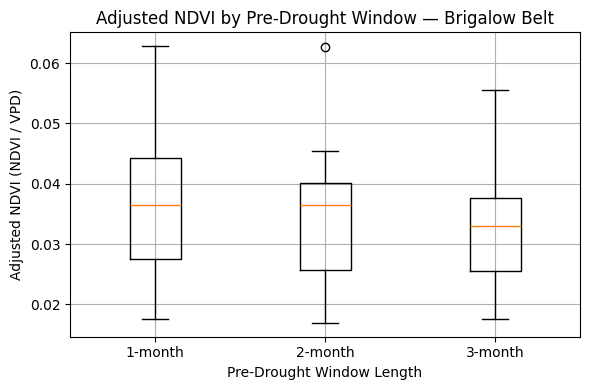

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


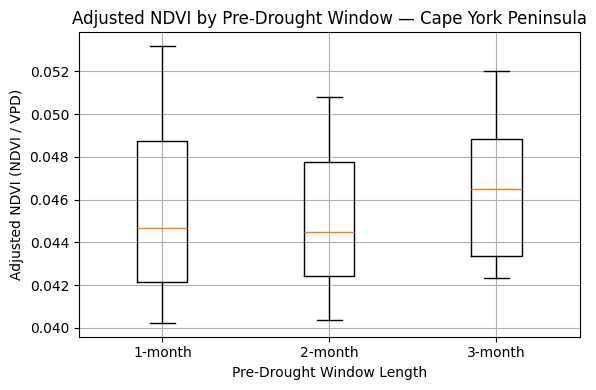

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


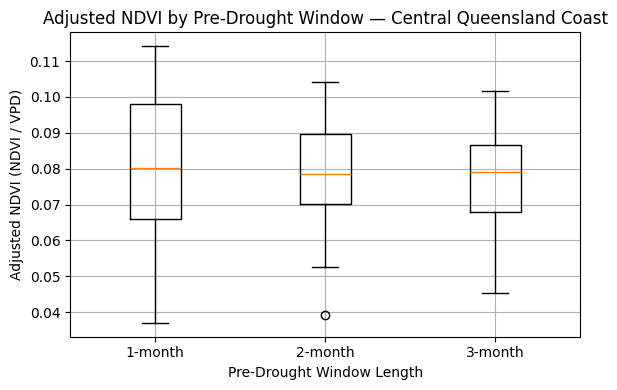

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


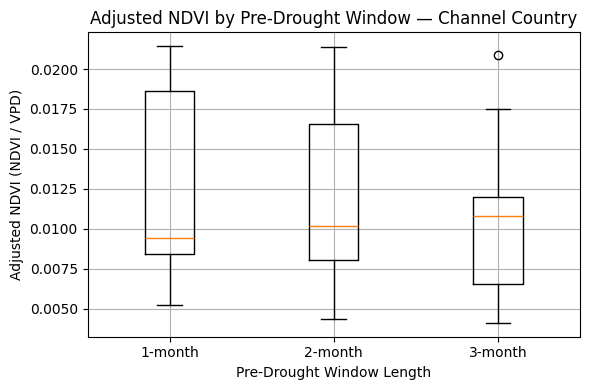

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


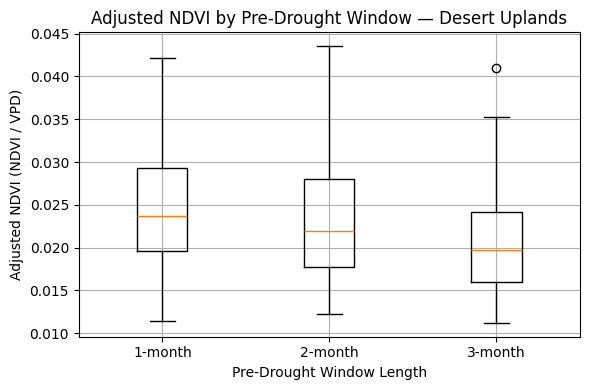

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


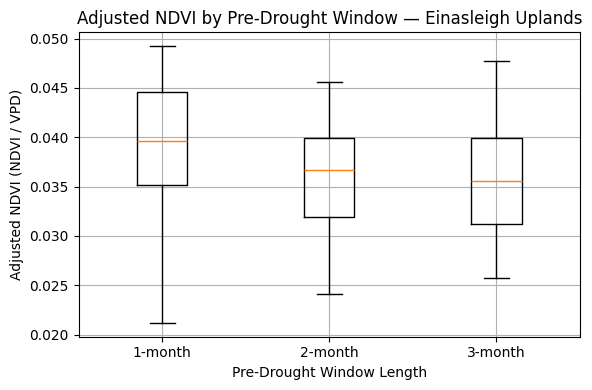

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


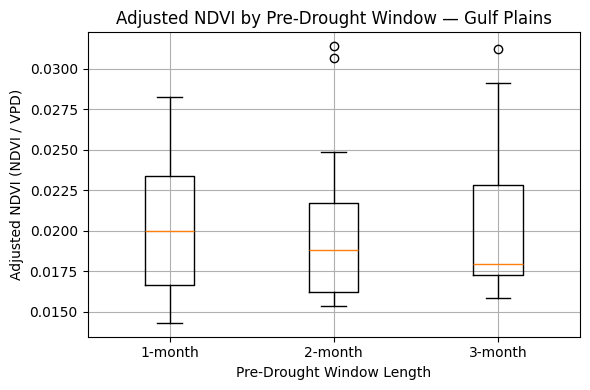

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


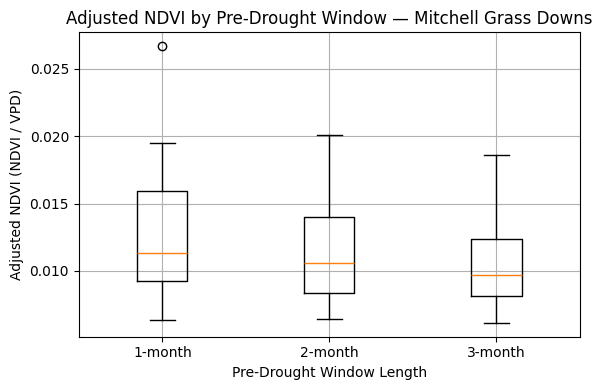

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


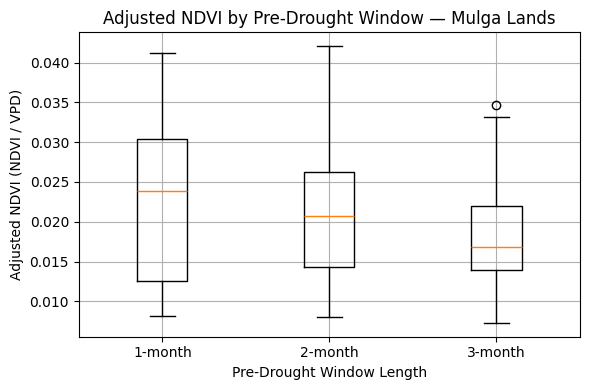

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


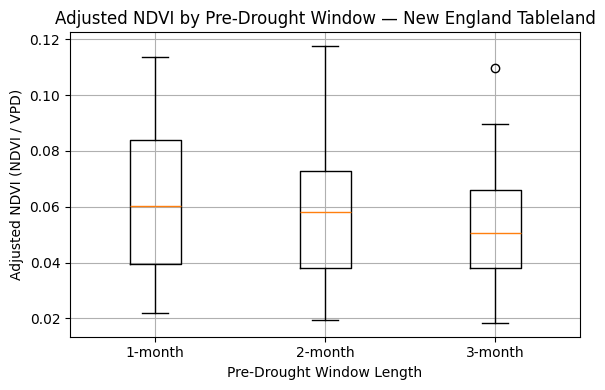

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


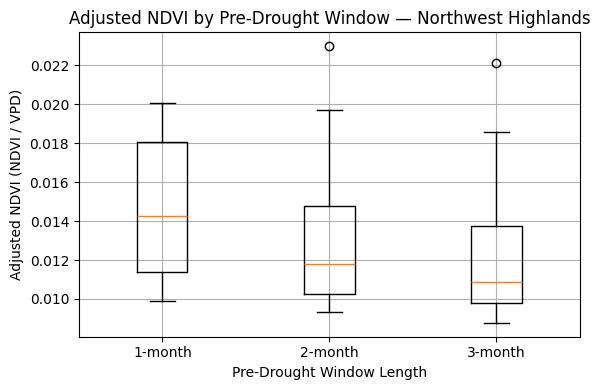

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


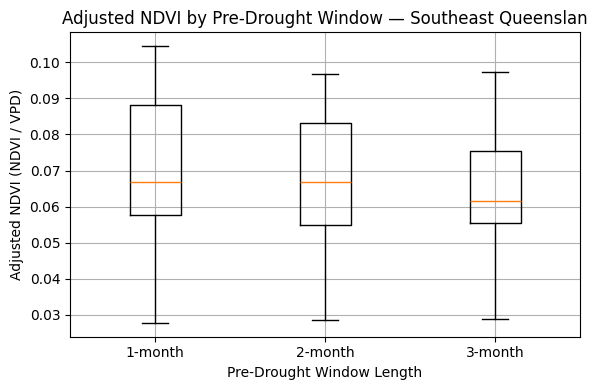

C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1829200269.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])


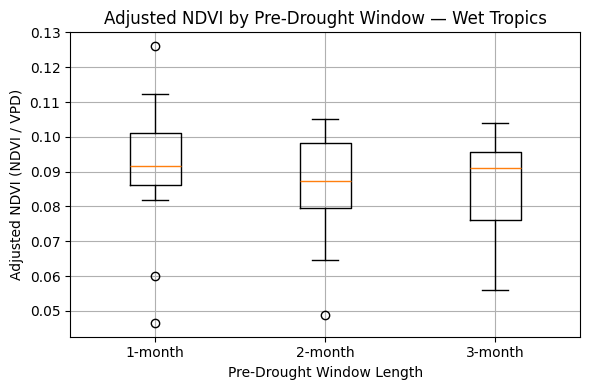

In [15]:
# Create one plot per region
for region in region_adj_ndvi:
    plt.figure(figsize=(6, 4))
    data = [region_adj_ndvi[region][w] for w in window_lengths]
    plt.boxplot(data, labels=[f"{w}-month" for w in window_lengths])
    plt.title(f"Adjusted NDVI by Pre-Drought Window — {region}")
    plt.ylabel("Adjusted NDVI (NDVI / VPD)")
    plt.xlabel("Pre-Drought Window Length")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

df = pd.read_csv("Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(["Region_Name", "Date"]).reset_index(drop=True)

windows = [1, 2, 3]
all_durations = defaultdict(lambda: defaultdict(list))  # region → window → list of durations

for region in df["Region_Name"].unique():
    region_df = df[df["Region_Name"] == region].reset_index(drop=True)

    for i in range(3, len(region_df)-6):  # avoid out-of-bound
        # Drought start condition
        if (region_df.loc[i, "SPI"] < -1) and (region_df.loc[i-1, "SPI"] >= -0.5):
            drought_start = region_df.loc[i, "Date"]
            
            # Drought end = when SPI ≥ -0.5 (recovery begins)
            for j in range(i+1, len(region_df)):
                if region_df.loc[j, "SPI"] >= -0.5:
                    drought_end_idx = j
                    drought_end = region_df.loc[j, "Date"]
                    break
            else:
                continue  # no end found

            # Loop over each window
            for w in windows:
                pre_drought = region_df[(region_df["Date"] < drought_start)].tail(w)
                if len(pre_drought) < w:
                    continue

                ndvi_baseline = pre_drought["NDVI"].mean()

                # Check recovery (within 6 months max)
                for k in range(drought_end_idx, min(drought_end_idx+6, len(region_df))):
                    if (region_df.loc[k, "NDVI"] >= ndvi_baseline) and (region_df.loc[k, "SPI"] >= -0.5):
                        recovery_duration = (region_df.loc[k, "Date"] - drought_end).days // 30
                        all_durations[region][w].append(recovery_duration)
                        break


<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\649838273.py:5: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv")


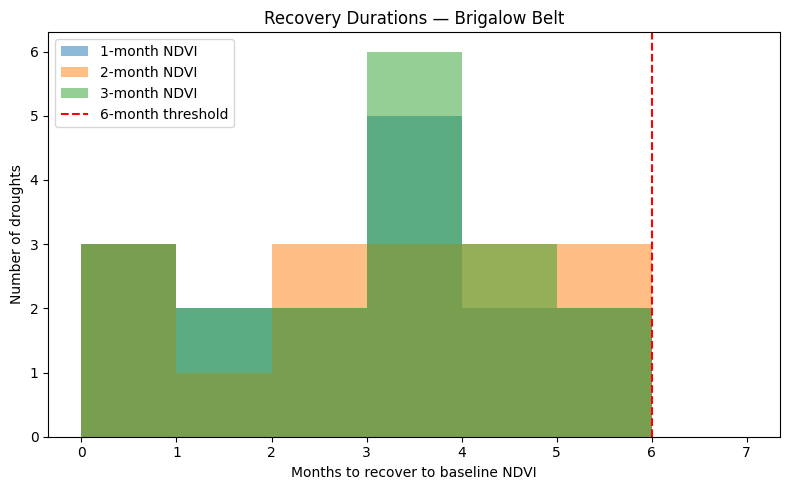

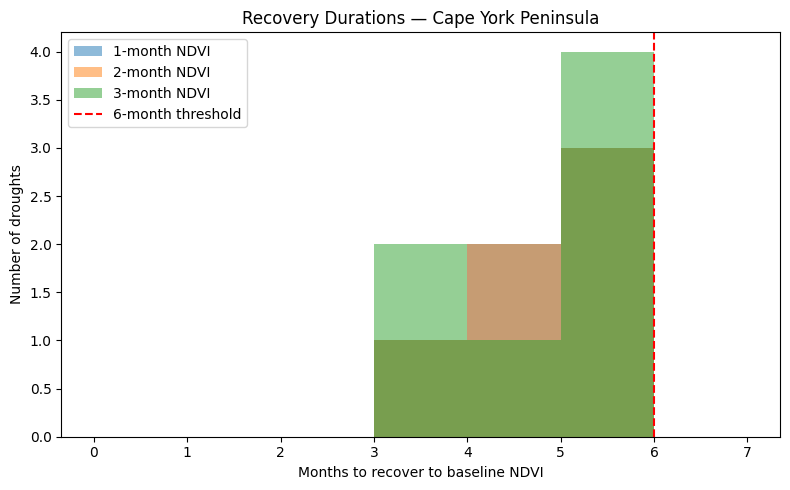

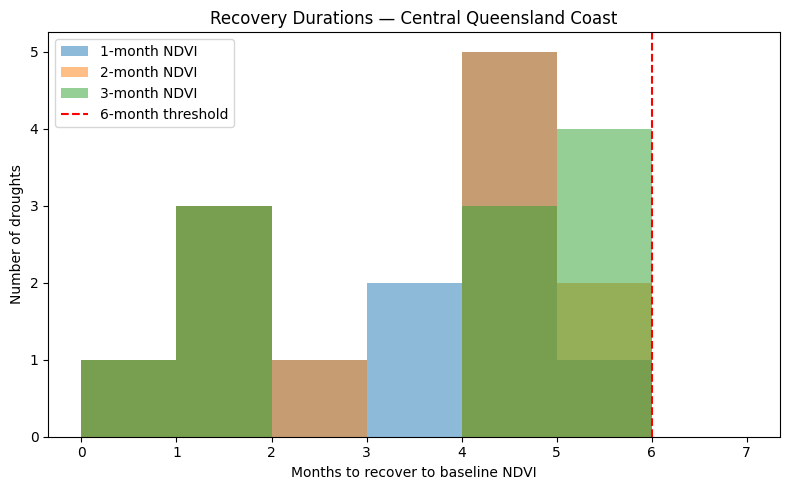

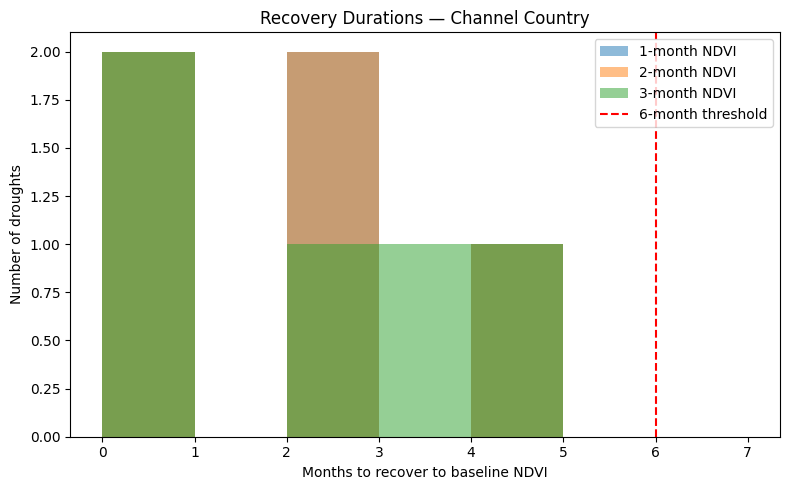

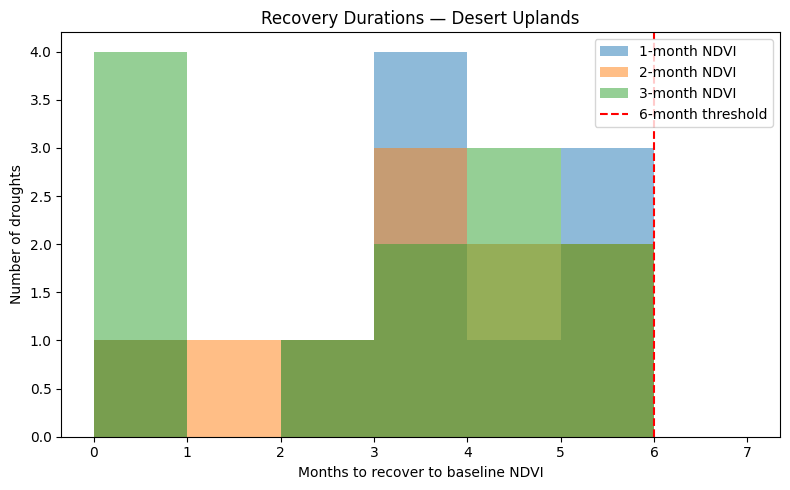

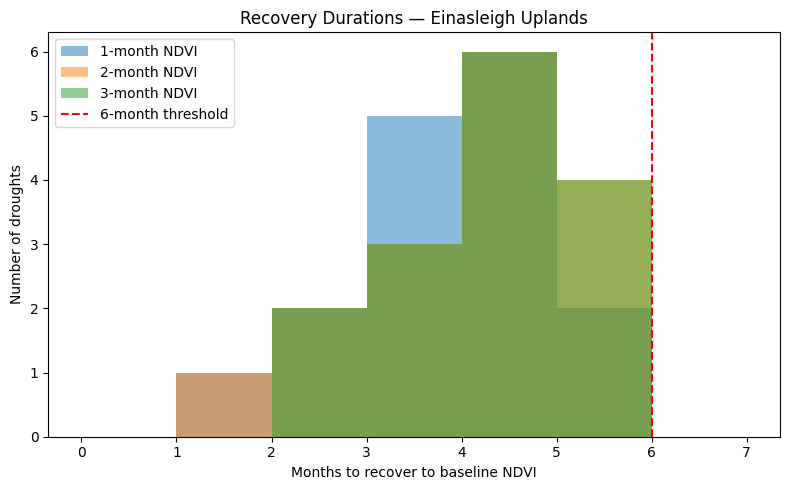

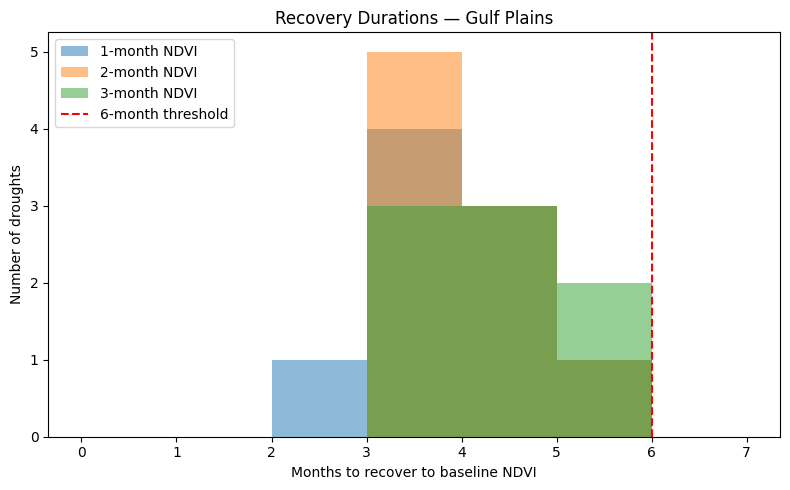

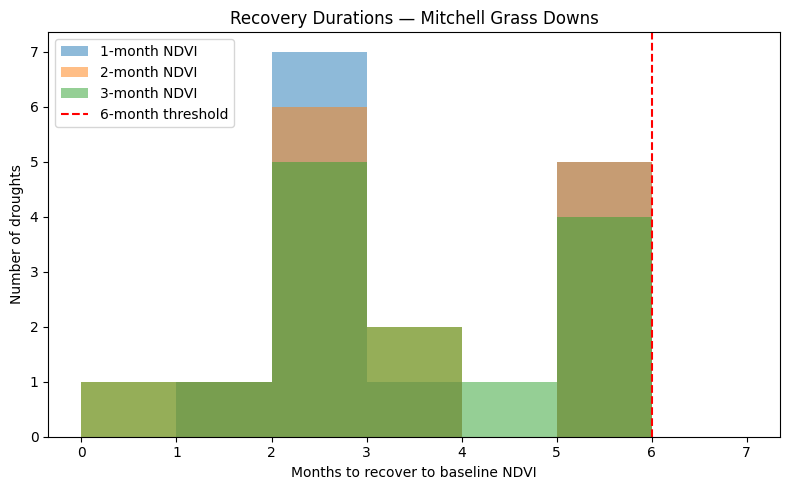

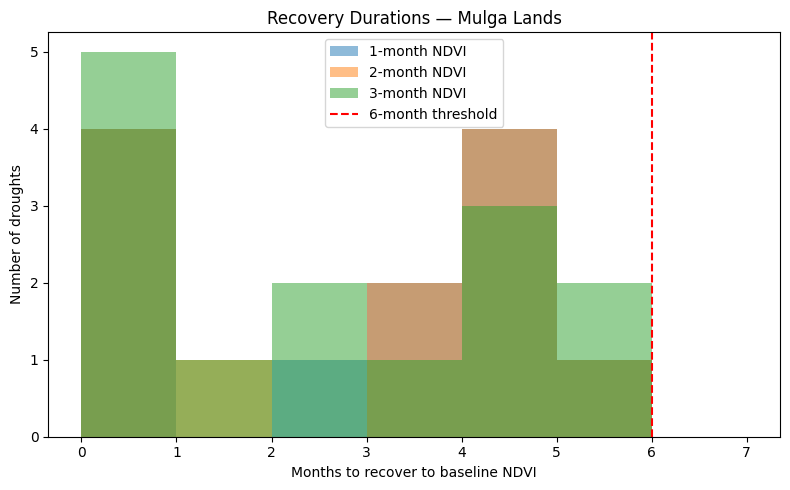

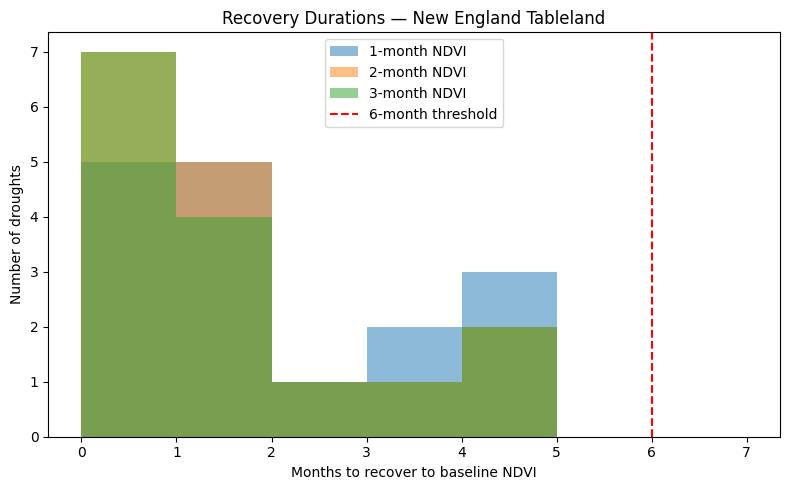

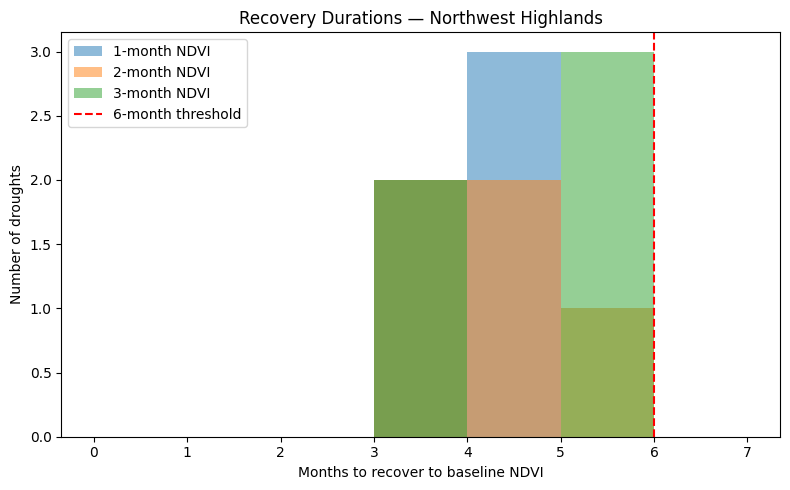

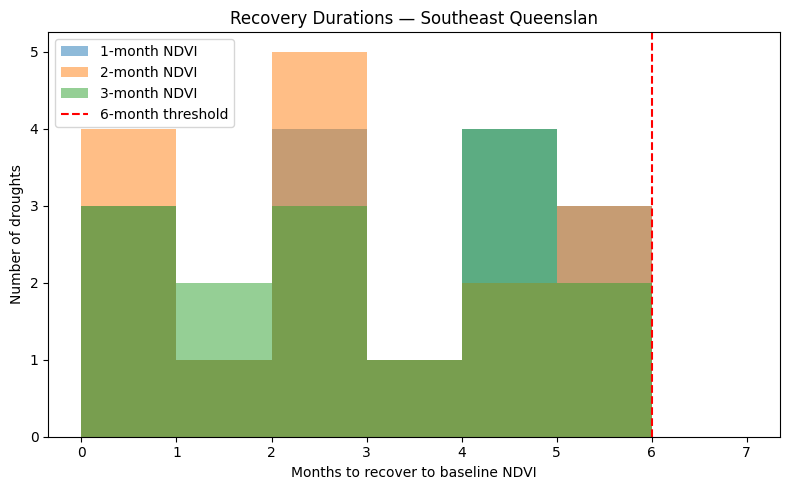

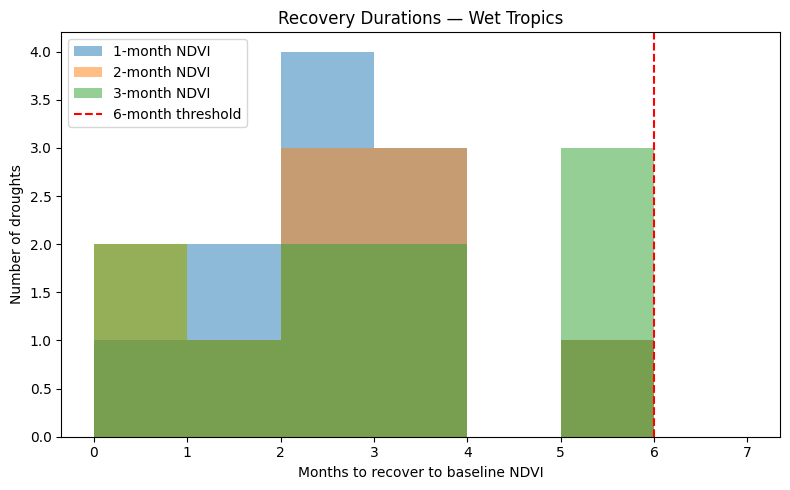

In [17]:
for region in all_durations:
    plt.figure(figsize=(8, 5))
    for w in windows:
        durations = all_durations[region][w]
        plt.hist(durations, bins=range(0, 8), alpha=0.5, label=f"{w}-month NDVI")
    plt.title(f"Recovery Durations — {region}")
    plt.xlabel("Months to recover to baseline NDVI")
    plt.ylabel("Number of droughts")
    plt.axvline(x=6, color='red', linestyle='--', label="6-month threshold")
    plt.legend()
    plt.tight_layout()
    plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1985320269.py:6: SyntaxWarning: invalid escape sequence '\M'
  file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv"  # Update with your file path


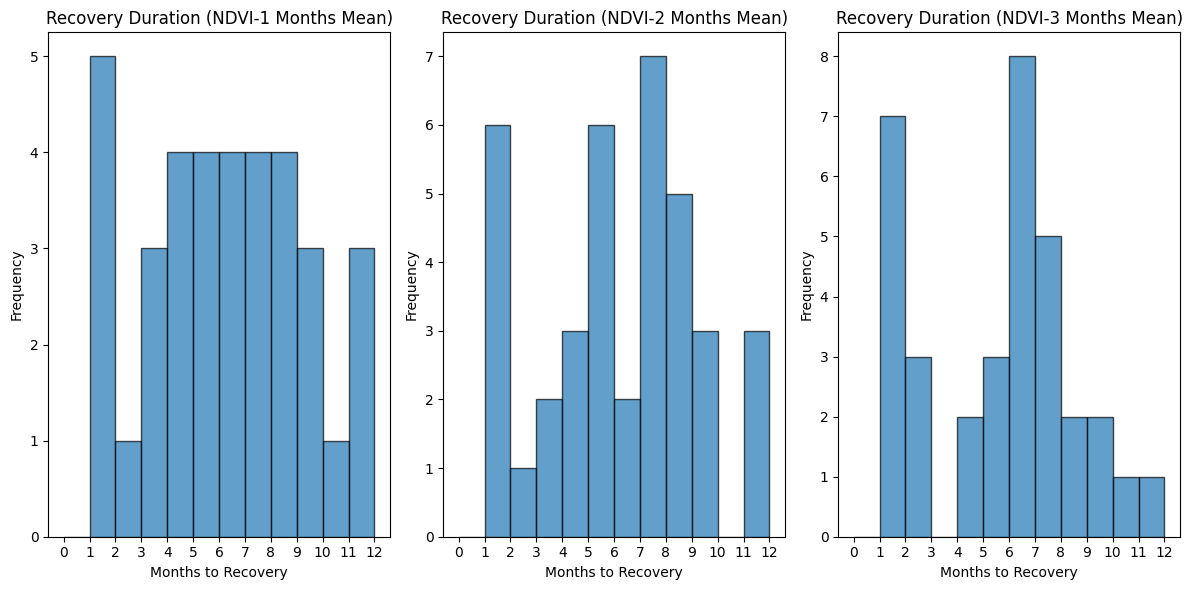

Percentage of recoveries within 6 months (NDVI-1 Months Mean): 58.33%
Percentage of recoveries within 6 months (NDVI-2 Months Mean): 52.63%
Percentage of recoveries within 6 months (NDVI-3 Months Mean): 67.65%


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv"  # Update with your file path
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(["Region_Name", "Date"]).reset_index(drop=True)

# Function to calculate the moving average for a given window size (1, 2, 3 months)
def moving_average(df, window_size, region_name):
    region_df = df[df["Region_Name"] == region_name].copy()
    region_df['NDVI_ma'] = region_df['NDVI'].rolling(window=window_size, min_periods=1).mean()
    return region_df

# Function to calculate recovery duration for each drought event
def calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx, max_months=12):
    recovery_durations = []
    for k in range(drought_end_idx, min(drought_end_idx + max_months, len(region_df))):
        if (region_df.loc[k, "SPI"] >= -0.5) and (region_df.loc[k, "NDVI"] >= baseline_ndvi):
            recovery_duration = (region_df.loc[k, "Date"] - region_df.loc[drought_end_idx, "Date"]).days // 30
            recovery_durations.append(recovery_duration)
            if recovery_duration <= 6:  # Stop early if recovery happens within 6 months
                break
    return recovery_durations

# Function to process and plot recovery for all regions
def plot_recovery_for_all_regions(df):
    recovery_results = {1: [], 2: [], 3: []}  # Store recovery results for 1-, 2-, and 3-month NDVI means
    
    for region in df['Region_Name'].unique():
        # Calculate moving averages for 1, 2, and 3 months
        for window_size in [1, 2, 3]:
            region_df = moving_average(df, window_size, region)
            
            # Identify drought events and calculate recovery duration
            for idx, row in region_df.iterrows():
                if row['SPI'] < -1:
                    # Find the end of the drought event
                    drought_end_idx = idx
                    baseline_ndvi = region_df.loc[drought_end_idx - window_size, 'NDVI_ma']
                    recovery_durations = calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx)
                    
                    # Add recovery durations to results
                    recovery_results[window_size].extend(recovery_durations)

    # Plot histograms of recovery durations for 1, 2, and 3 months
    plt.figure(figsize=(12, 6))
    for i, window_size in enumerate([1, 2, 3], 1):
        plt.subplot(1, 3, i)
        plt.hist(recovery_results[window_size], bins=range(0, 13), edgecolor='black', alpha=0.7)
        plt.title(f"Recovery Duration (NDVI-{window_size} Months Mean)")
        plt.xlabel('Months to Recovery')
        plt.ylabel('Frequency')
        plt.xticks(np.arange(0, 13, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Calculate the percentage of droughts recovered within 6 months for each window
    for window_size in [1, 2, 3]:
        total_recoveries = len(recovery_results[window_size])
        recoveries_within_6_months = sum(1 for x in recovery_results[window_size] if x <= 6)
        recovery_percentage = (recoveries_within_6_months / total_recoveries) * 100 if total_recoveries > 0 else 0
        print(f"Percentage of recoveries within 6 months (NDVI-{window_size} Months Mean): {recovery_percentage:.2f}%")
    
# Call the function to plot and calculate recovery durations
plot_recovery_for_all_regions(df)


<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\4256582888.py:7: SyntaxWarning: invalid escape sequence '\M'
  file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv"  # Update with your file path
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\4256582888.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Recovery Category', loc='upper right')
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\4256582888.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Recovery Category', loc='upper right')
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\4256582888.py:75: Us

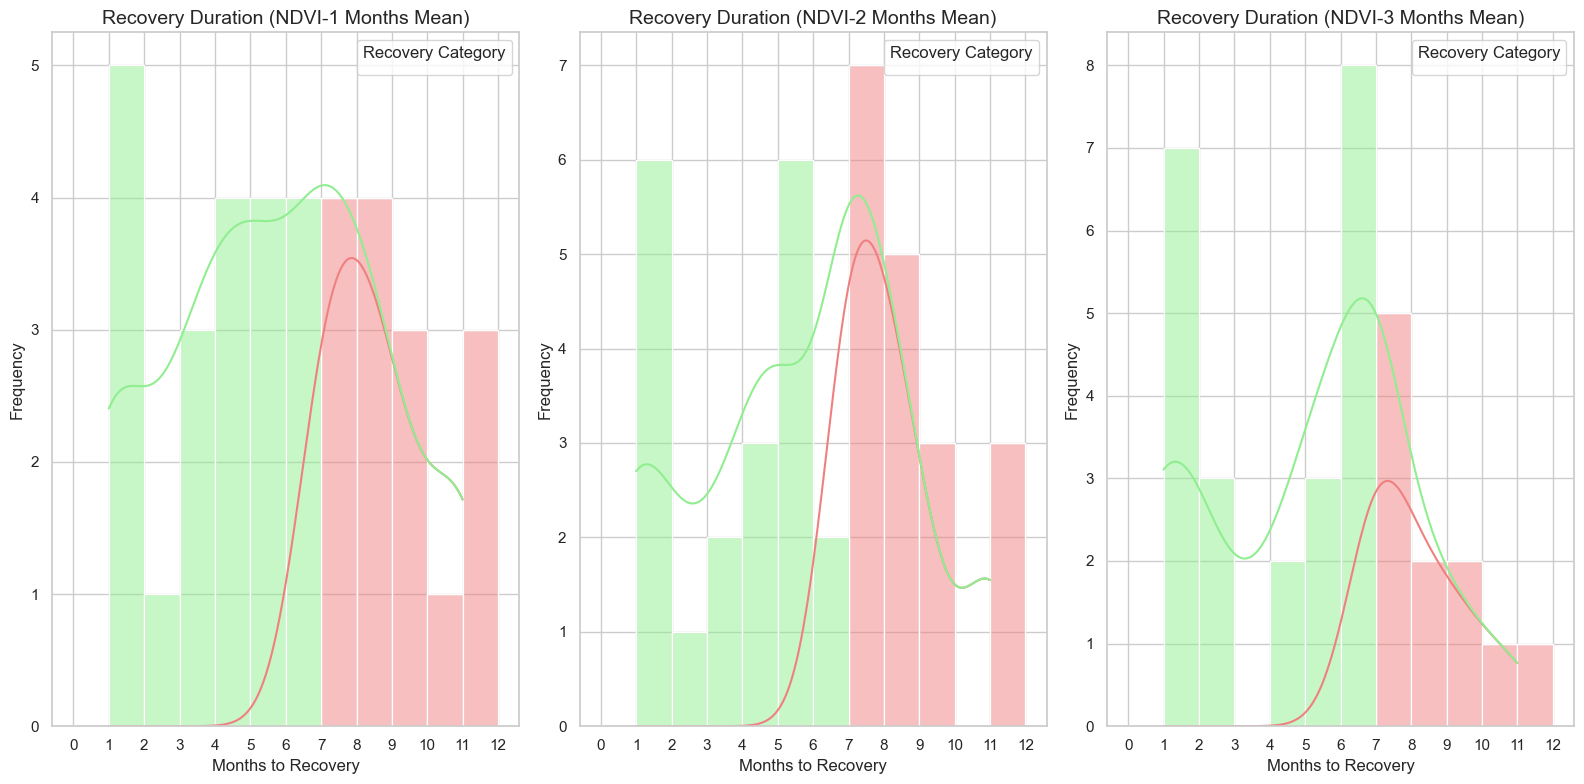

Percentage of recoveries within 6 months (NDVI-1 Months Mean): 58.33%
Percentage of recoveries within 6 months (NDVI-2 Months Mean): 52.63%
Percentage of recoveries within 6 months (NDVI-3 Months Mean): 67.65%


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv"  # Update with your file path
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(["Region_Name", "Date"]).reset_index(drop=True)

# Function to calculate the moving average for a given window size (1, 2, 3 months)
def moving_average(df, window_size, region_name):
    region_df = df[df["Region_Name"] == region_name].copy()
    region_df['NDVI_ma'] = region_df['NDVI'].rolling(window=window_size, min_periods=1).mean()
    return region_df

# Function to calculate recovery duration for each drought event
def calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx, max_months=12):
    recovery_durations = []
    for k in range(drought_end_idx, min(drought_end_idx + max_months, len(region_df))):
        if (region_df.loc[k, "SPI"] >= -0.5) and (region_df.loc[k, "NDVI"] >= baseline_ndvi):
            recovery_duration = (region_df.loc[k, "Date"] - region_df.loc[drought_end_idx, "Date"]).days // 30
            recovery_durations.append(recovery_duration)
            if recovery_duration <= 6:  # Stop early if recovery happens within 6 months
                break
    return recovery_durations

# Function to process and plot recovery for all regions
def plot_recovery_for_all_regions(df):
    recovery_results = {1: [], 2: [], 3: []}  # Store recovery results for 1-, 2-, and 3-month NDVI means
    
    for region in df['Region_Name'].unique():
        # Calculate moving averages for 1, 2, and 3 months
        for window_size in [1, 2, 3]:
            region_df = moving_average(df, window_size, region)
            
            # Identify drought events and calculate recovery duration
            for idx, row in region_df.iterrows():
                if row['SPI'] < -1:
                    # Find the end of the drought event
                    drought_end_idx = idx
                    baseline_ndvi = region_df.loc[drought_end_idx - window_size, 'NDVI_ma']
                    recovery_durations = calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx)
                    
                    # Add recovery durations to results
                    recovery_results[window_size].extend(recovery_durations)

    # Plot histograms of recovery durations for 1, 2, and 3 months using Seaborn
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(16, 8))
    
    for i, window_size in enumerate([1, 2, 3], 1):
        plt.subplot(1, 3, i)
        
        # Separate the durations that are within 6 months and beyond
        within_6_months = [x for x in recovery_results[window_size] if x <= 6]
        beyond_6_months = [x for x in recovery_results[window_size] if x > 6]
        
        # Create a DataFrame for better handling with Seaborn
        data = {
            'Recovery Duration': within_6_months + beyond_6_months,
            'Category': ['Recovery ≤ 6 months'] * len(within_6_months) + ['Recovery > 6 months'] * len(beyond_6_months)
        }
        df_plot = pd.DataFrame(data)
        
        # Plot the histogram using Seaborn's histplot with KDE
        sns.histplot(df_plot, x='Recovery Duration', hue='Category', multiple="stack", kde=True, bins=np.arange(0, 13, 1), palette=["lightgreen", "lightcoral"], linewidth=1)
        
        # Add titles, labels, and grid for better readability
        plt.title(f"Recovery Duration (NDVI-{window_size} Months Mean)", fontsize=14)
        plt.xlabel('Months to Recovery', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(np.arange(0, 13, 1))
        plt.legend(title='Recovery Category', loc='upper right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Calculate the percentage of droughts recovered within 6 months for each window
    for window_size in [1, 2, 3]:
        total_recoveries = len(recovery_results[window_size])
        recoveries_within_6_months = sum(1 for x in recovery_results[window_size] if x <= 6)
        recovery_percentage = (recoveries_within_6_months / total_recoveries) * 100 if total_recoveries > 0 else 0
        print(f"Percentage of recoveries within 6 months (NDVI-{window_size} Months Mean): {recovery_percentage:.2f}%")
    
# Call the function to plot and calculate recovery durations
plot_recovery_for_all_regions(df)


<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
C:\Users\u1171032\AppData\Local\Temp\ipykernel_19172\1692608820.py:7: SyntaxWarning: invalid escape sequence '\M'
  file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv"  # Update with your file path


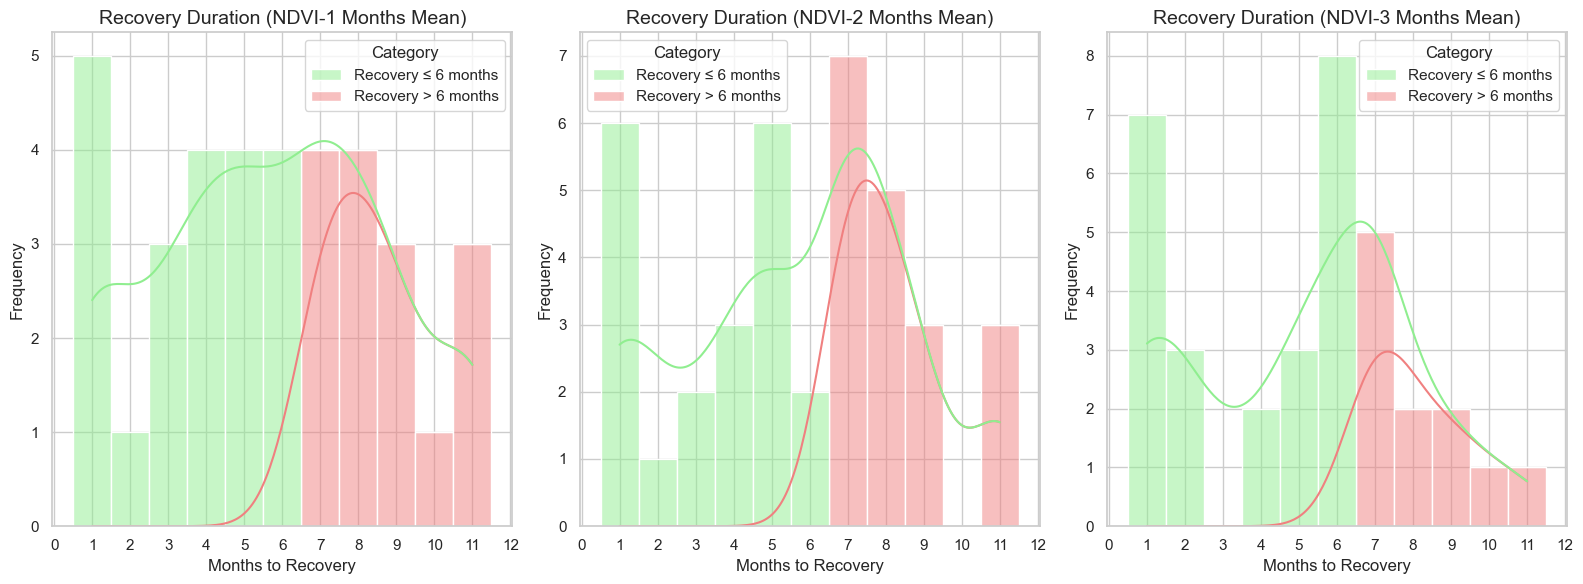

Percentage of recoveries within 6 months (NDVI-1 Months Mean): 58.33%
Percentage of recoveries within 6 months (NDVI-2 Months Mean): 52.63%
Percentage of recoveries within 6 months (NDVI-3 Months Mean): 67.65%


In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\cleaned_file_without_2023.csv"  # Update with your file path
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(["Region_Name", "Date"]).reset_index(drop=True)

# Function to calculate the moving average for a given window size (1, 2, 3 months)
def moving_average(df, window_size, region_name):
    region_df = df[df["Region_Name"] == region_name].copy()
    region_df['NDVI_ma'] = region_df['NDVI'].rolling(window=window_size, min_periods=1).mean()
    return region_df

# Function to calculate recovery duration for each drought event
def calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx, max_months=12):
    recovery_durations = []
    for k in range(drought_end_idx, min(drought_end_idx + max_months, len(region_df))):
        if (region_df.loc[k, "SPI"] >= -0.5) and (region_df.loc[k, "NDVI"] >= baseline_ndvi):
            recovery_duration = (region_df.loc[k, "Date"] - region_df.loc[drought_end_idx, "Date"]).days // 30
            recovery_durations.append(recovery_duration)
            if recovery_duration <= 6:  # Stop early if recovery happens within 6 months
                break
    return recovery_durations

# Function to process and plot recovery for all regions
def plot_recovery_for_all_regions(df):
    recovery_results = {1: [], 2: [], 3: []}  # Store recovery results for 1-, 2-, and 3-month NDVI means
    
    for region in df['Region_Name'].unique():
        # Calculate moving averages for 1, 2, and 3 months
        for window_size in [1, 2, 3]:
            region_df = moving_average(df, window_size, region)
            
            # Identify drought events and calculate recovery duration
            for idx, row in region_df.iterrows():
                if row['SPI'] < -1:
                    # Find the end of the drought event
                    drought_end_idx = idx
                    baseline_ndvi = region_df.loc[drought_end_idx - window_size, 'NDVI_ma']
                    recovery_durations = calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx)
                    
                    # Add recovery durations to results
                    recovery_results[window_size].extend(recovery_durations) 

    # Plot histograms of recovery durations for 1, 2, and 3 months using Seaborn
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(16, 6))  # Reduced the height here
    
    for i, window_size in enumerate([1, 2, 3], 1):
        plt.subplot(1, 3, i)
        
        # Separate the durations that are within 6 months and beyond
        within_6_months = [x for x in recovery_results[window_size] if x <= 6]
        beyond_6_months = [x for x in recovery_results[window_size] if x > 6]
        
        # Create a DataFrame for better handling with Seaborn
        data = {
            'Recovery Duration': within_6_months + beyond_6_months,
            'Category': ['Recovery ≤ 6 months'] * len(within_6_months) + ['Recovery > 6 months'] * len(beyond_6_months)
        }
        df_plot = pd.DataFrame(data)
        
        # Plot the histogram using Seaborn's histplot with KDE
        ax = sns.histplot(df_plot, x='Recovery Duration', hue='Category', multiple="stack", kde=True, discrete=True, palette=["lightgreen", "lightcoral"], linewidth=1)
        
        # # Customize the spines and grid
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_visible(True)  # Keep only the x-axis

        ax.grid(False, axis='y')  # Remove y-axis grid lines

        # Add titles, labels, and grid for better readability
        plt.title(f"Recovery Duration (NDVI-{window_size} Months Mean)", fontsize=14)
        plt.xlabel('Months to Recovery', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(np.arange(0, 13, 1))
        # plt.legend(title='Recovery Category', loc='upper right')
        plt.grid(True)
        

    plt.tight_layout()
    plt.show()
    
    # Calculate the percentage of droughts recovered within 6 months for each window
    for window_size in [1, 2, 3]:
        total_recoveries = len(recovery_results[window_size])
        recoveries_within_6_months = sum(1 for x in recovery_results[window_size] if x <= 6)
        recovery_percentage = (recoveries_within_6_months / total_recoveries) * 100 if total_recoveries > 0 else 0
        print(f"Percentage of recoveries within 6 months (NDVI-{window_size} Months Mean): {recovery_percentage:.2f}%")

    
# Call the function to plot and calculate recovery durations
plot_recovery_for_all_regions(df)


<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Jspch\AppData\Local\Temp\ipykernel_28944\3665039880.py:7: SyntaxWarning: invalid escape sequence '\M'
  file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\merged_file.csv"  # Update with your file path


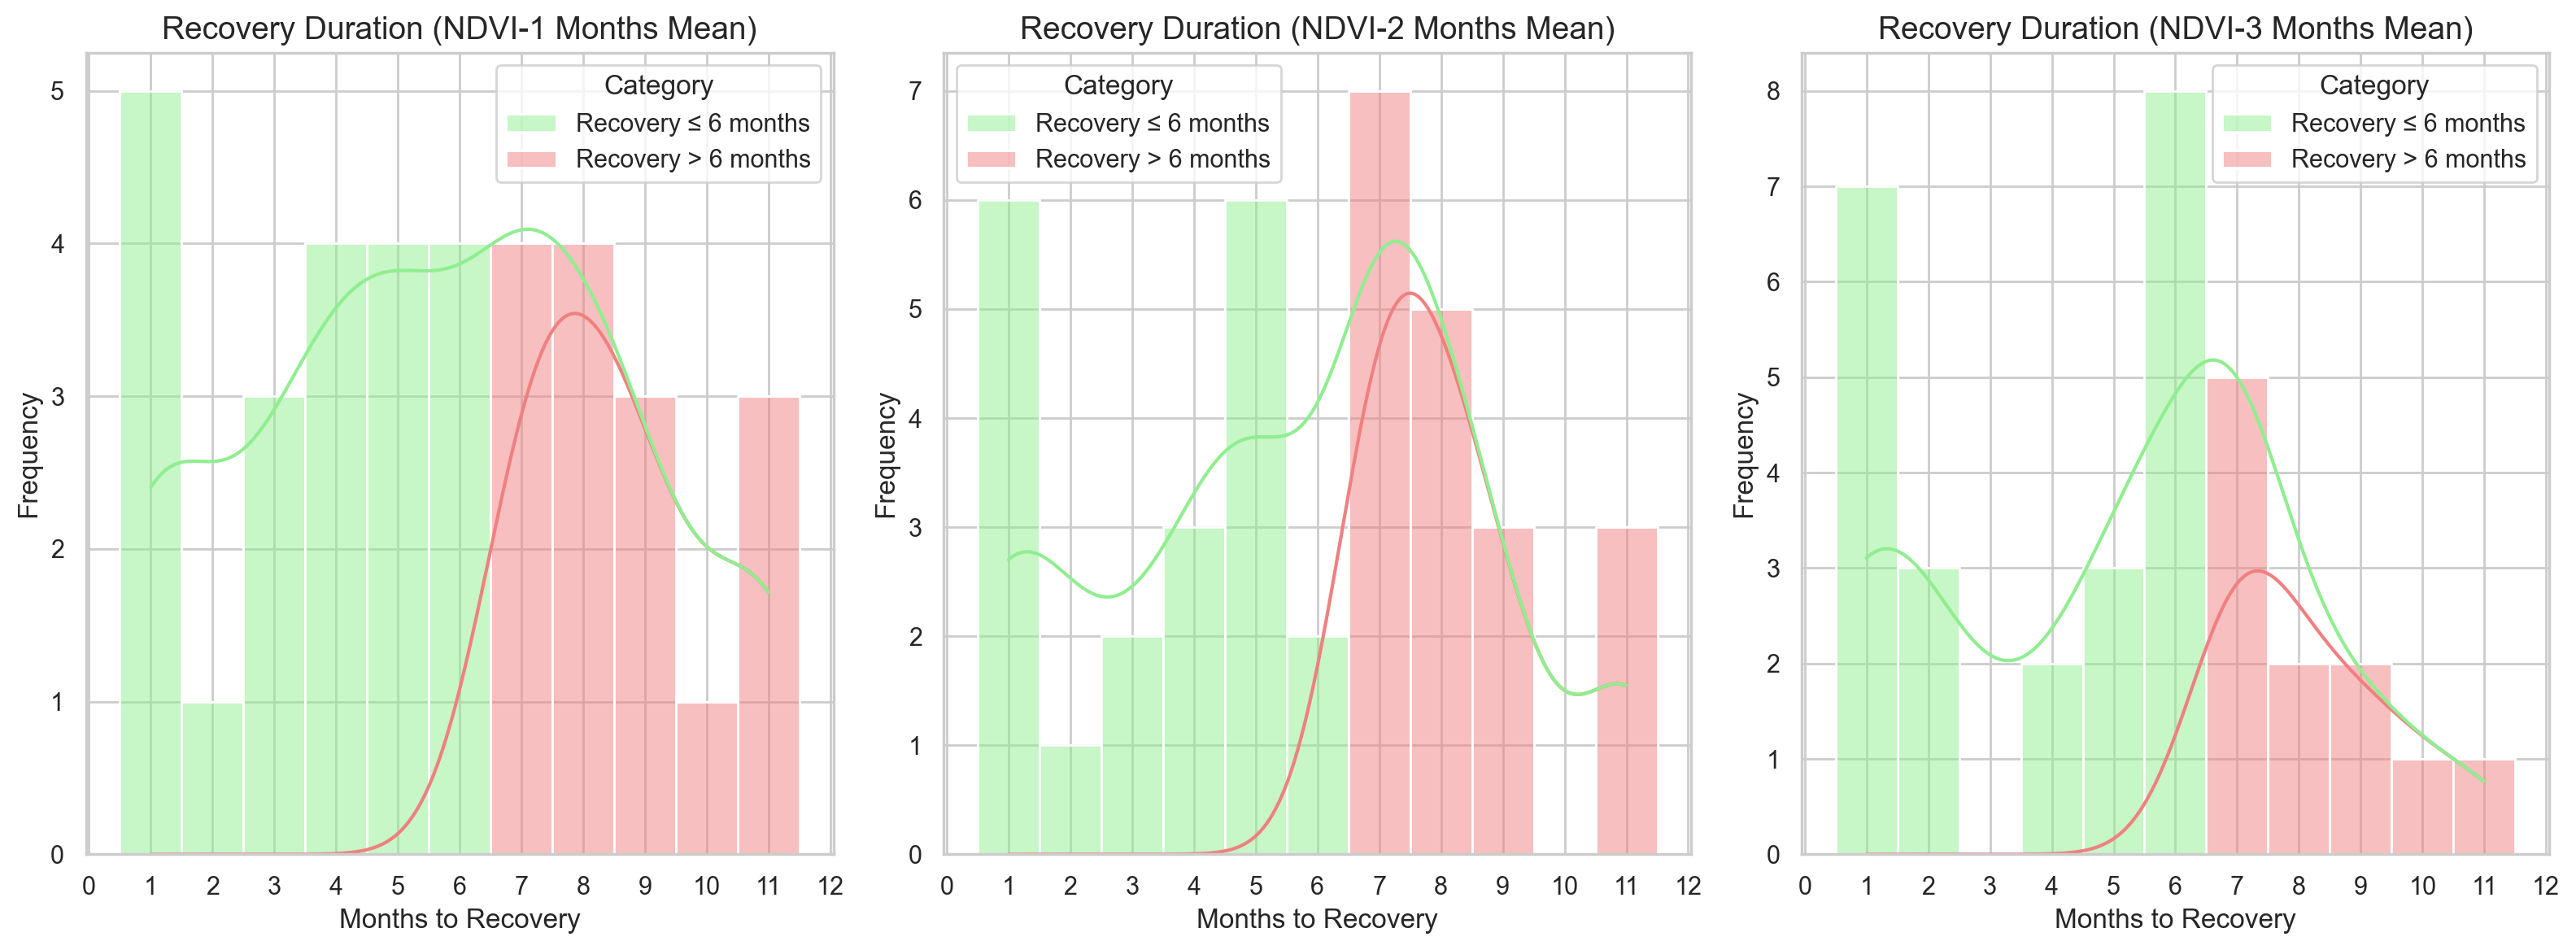

Percentage of recoveries within 6 months (NDVI-1 Months Mean): 58.33%
Percentage of recoveries within 6 months (NDVI-2 Months Mean): 52.63%
Percentage of recoveries within 6 months (NDVI-3 Months Mean): 67.65%


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Data\Merged SPI & NDVI & VPD\Cleaned\merged_file.csv"  # Update with your file path
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(["Region_Name", "Date"]).reset_index(drop=True)

# Function to calculate the moving average for a given window size (1, 2, 3 months)
def moving_average(df, window_size, region_name):
    region_df = df[df["Region_Name"] == region_name].copy()
    region_df['NDVI_ma'] = region_df['NDVI'].rolling(window=window_size, min_periods=1).mean()
    return region_df

# Function to calculate recovery duration for each drought event
def calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx, max_months=12):
    recovery_durations = []
    for k in range(drought_end_idx, min(drought_end_idx + max_months, len(region_df))):
        if (region_df.loc[k, "SPI"] >= -0.5) and (region_df.loc[k, "NDVI"] >= baseline_ndvi):
            recovery_duration = (region_df.loc[k, "Date"] - region_df.loc[drought_end_idx, "Date"]).days // 30
            recovery_durations.append(recovery_duration)
            if recovery_duration <= 6:  # Stop early if recovery happens within 6 months
                break
    return recovery_durations

# Function to process and plot recovery for all regions
def plot_recovery_for_all_regions(df):
    recovery_results = {1: [], 2: [], 3: []}  # Store recovery results for 1-, 2-, and 3-month NDVI means
    
    for region in df['Region_Name'].unique():
        # Calculate moving averages for 1, 2, and 3 months
        for window_size in [1, 2, 3]:
            region_df = moving_average(df, window_size, region)
            
            # Identify drought events and calculate recovery duration
            for idx, row in region_df.iterrows():
                if row['SPI'] < -1:
                    # Find the end of the drought event
                    drought_end_idx = idx
                    baseline_ndvi = region_df.loc[drought_end_idx - window_size, 'NDVI_ma']
                    recovery_durations = calculate_recovery_duration(region_df, baseline_ndvi, drought_end_idx)
                    
                    # Add recovery durations to results
                    recovery_results[window_size].extend(recovery_durations) 

    # Plot histograms of recovery durations for 1, 2, and 3 months using Seaborn
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(16, 6), dpi=200)  # Reduced the height here
    
    for i, window_size in enumerate([1, 2, 3], 1):
        plt.subplot(1, 3, i)
        
        # Separate the durations that are within 6 months and beyond
        within_6_months = [x for x in recovery_results[window_size] if x <= 6]
        beyond_6_months = [x for x in recovery_results[window_size] if x > 6]
        
        # Create a DataFrame for better handling with Seaborn
        data = {
            'Recovery Duration': within_6_months + beyond_6_months,
            'Category': ['Recovery ≤ 6 months'] * len(within_6_months) + ['Recovery > 6 months'] * len(beyond_6_months)
        }
        df_plot = pd.DataFrame(data)
        
        # Plot the histogram using Seaborn's histplot with KDE
        ax = sns.histplot(df_plot, x='Recovery Duration', hue='Category', multiple="stack", kde=True, discrete=True, palette=["lightgreen", "lightcoral"], linewidth=1)
        
        # # Customize the spines and grid
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_visible(True)  # Keep only the x-axis

        ax.grid(False, axis='y')  # Remove y-axis grid lines

        # Add titles, labels, and grid for better readability
        plt.title(f"Recovery Duration (NDVI-{window_size} Months Mean)", fontsize=14)
        plt.xlabel('Months to Recovery', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(np.arange(0, 13, 1))
        # plt.legend(title='Recovery Category', loc='upper right')
        plt.grid(True)
        

    plt.tight_layout()
    plt.show()
    
    # Calculate the percentage of droughts recovered within 6 months for each window
    for window_size in [1, 2, 3]:
        total_recoveries = len(recovery_results[window_size])
        recoveries_within_6_months = sum(1 for x in recovery_results[window_size] if x <= 6)
        recovery_percentage = (recoveries_within_6_months / total_recoveries) * 100 if total_recoveries > 0 else 0
        print(f"Percentage of recoveries within 6 months (NDVI-{window_size} Months Mean): {recovery_percentage:.2f}%")

    
# Call the function to plot and calculate recovery durations
plot_recovery_for_all_regions(df)
